In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Normalization( -1 ~ 1)
X_train = X_train.astype(np.float32) / 127.5 -1

# Reshape
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
from keras.optimizers import Adam
# beta_1 : 감쇠율 조정

adam = Adam(lr = 0.0002, beta_1 = 0.5)

# Generator Model

In [4]:
NOISE_DIM =10

generator = Sequential(name = 'generator')

generator.add(Dense(256, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation ='tanh')) # 784로 맞춰줘야 (X_train shape) Discriminator에서 input shape를 같이할 수 있어어

In [5]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               80

# Discriminator Model

In [6]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name='discriminator')
discriminator.add(Dense(1024, input_shape=(784,),
                        kernel_initializer = RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation='sigmoid'))

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

In [8]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Gan Model = Generator + Discriminator

In [9]:
discriminator.trainable = False # 학습시키지 X. 왜냐면 두개의 모델을 동시에 학습시키지 않기 때문

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

In [10]:
gan = Model(gan_input, output, name='gan')

In [11]:
gan.summary()

# Non_trainable params = Discriminator params

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [12]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

# Define 'get_batches' Function

In [13]:
# mnist image batch 생성
def get_batches(data, batch_size):
  batches=[]

  for i in range(data.shape[0] // batch_size):
    batch = data[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return np.asarray(batches)

In [15]:
print(X_train.shape[0])
print(X_train.shape[0]//128) 

60000
468


In [18]:
def visualize_training(epoch, d_losses, g_losses):

  print('epoch :', epoch)
  noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(-1, 28,28)

  plt.figure(figsize=(8,4))
  for i in range(generated_images.shape[0]):
    plt.subplot(4,6, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

epoch : 1


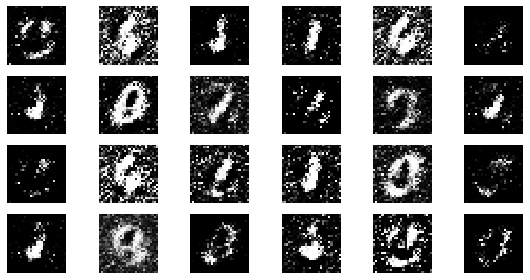

epoch : 5


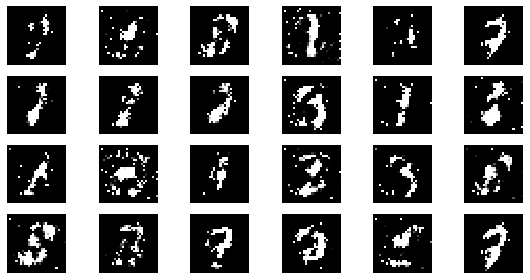

epoch : 10


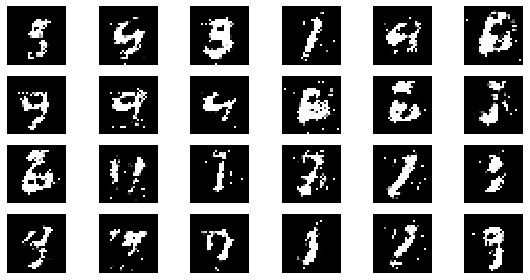

epoch : 15


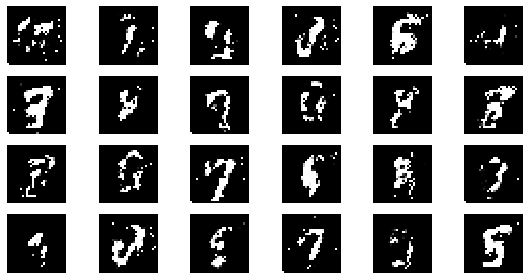

epoch : 20


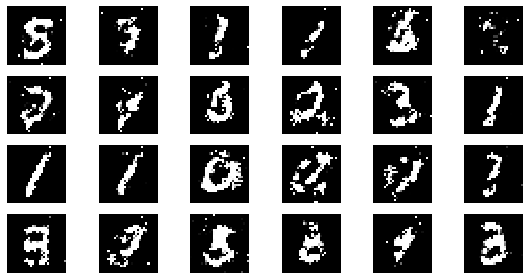

epoch : 25


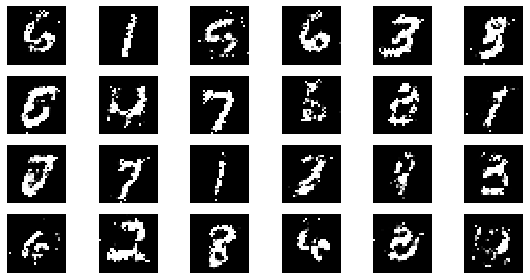

epoch : 30


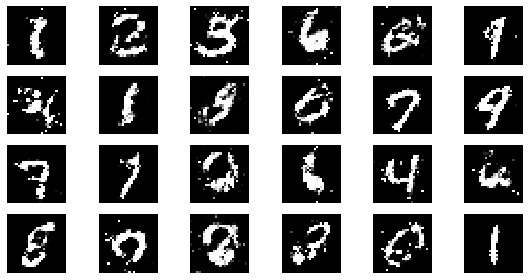

epoch : 35


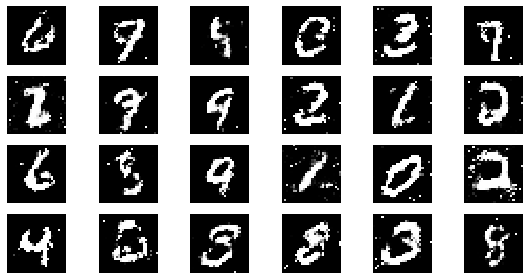

epoch : 40


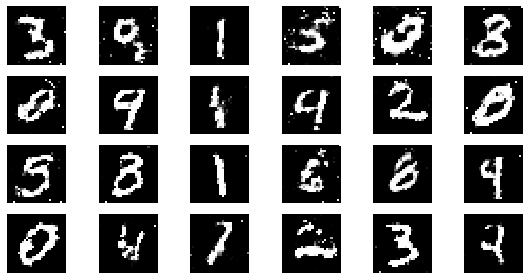

epoch : 45


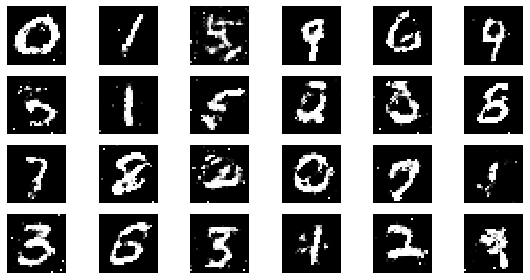

epoch : 50


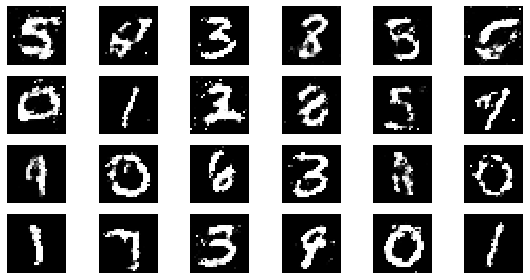

epoch : 55


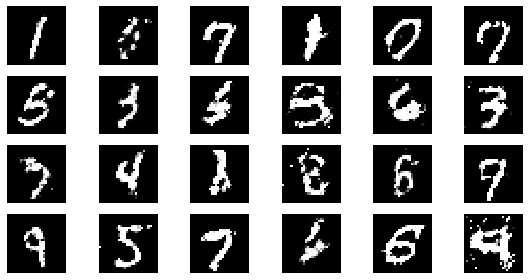

epoch : 60


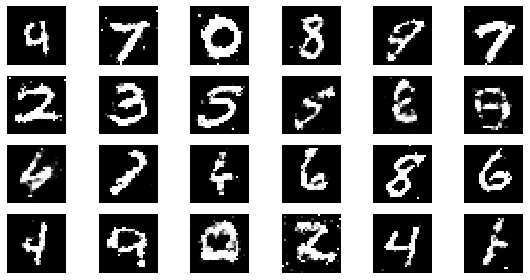

epoch : 65


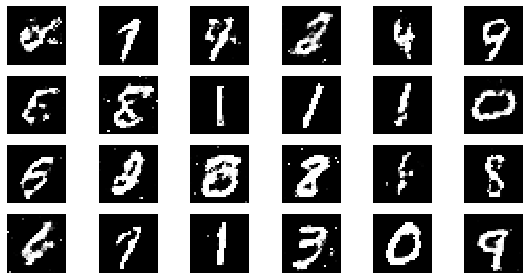

epoch : 70


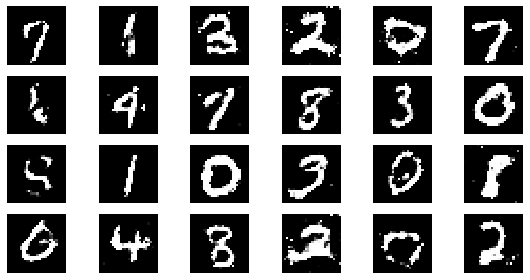

epoch : 75


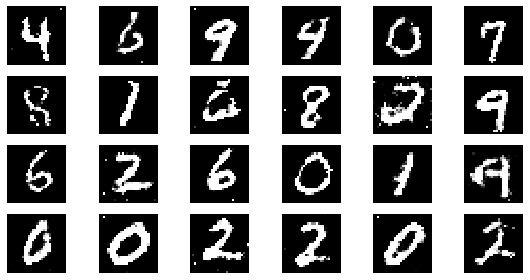

epoch : 80


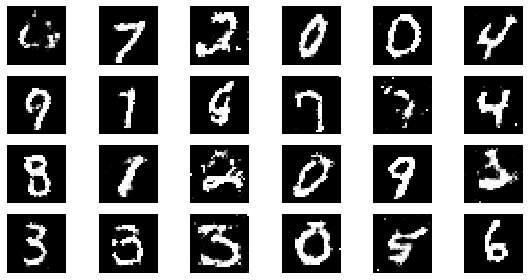

epoch : 85


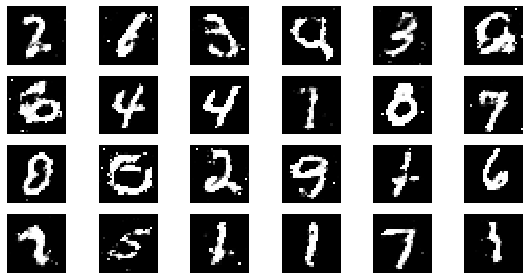

epoch : 90


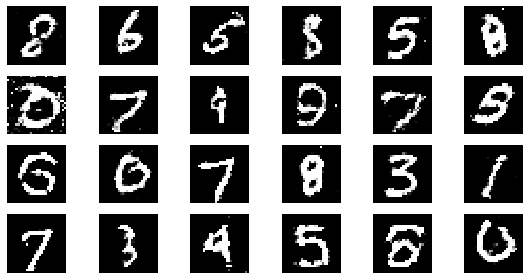

epoch : 95


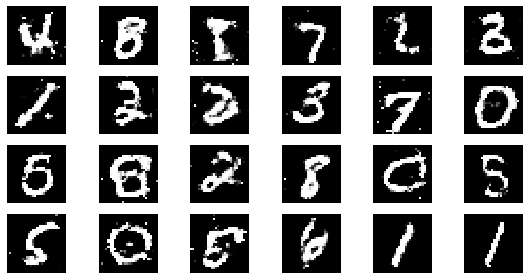

epoch : 100


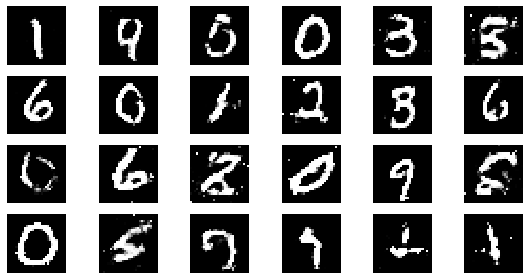

CPU times: user 32min 22s, sys: 1min 39s, total: 34min 1s
Wall time: 32min 38s


In [23]:
%%time

EPOCHS = 100
BATCH_SIZE = 128

d_losses=[]
g_losses=[]

for epoch in range(1, EPOCHS + 1):
  # batch별 학습
  for real_images in get_batches(X_train, BATCH_SIZE):
    # random Noise 생성
    input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    
    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise)

    # 'gan' 학습용 x 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])

    # 'gan' 학습용 y 데이터 정의
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1
    
    # 'discriminator' 학습
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)

    # gan 학습
    noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)
    
    # discriminator 학습정지
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # 생성 결과 시각화
  if epoch == 1 or epoch % 5 ==0 :
    visualize_training(epoch, d_losses, g_losses)

In [20]:
apple =np.zeros(2 * 100)
apple.shape

(200,)